# Final Project - Analysis of the Effect of Reach on the Number of Significant Strikes Landed per Min in the UFC Fights in Account to Heights
Group Members: Byeong Heon Ahn (bha233), Kanishk Aggarwal (ka3506), Dhruv Topiwala (dmt9779)

## Hypothesis

For this project, we will analyze the causal effect of the reach of the fighters on the number of significant strikes landed per min. To analyze both the total and direct causal effect of the reach on the number of significant strikes landed per min, we will use the reach and the number of significant strikes landed per min of the individual fighters on the blue side. The height of the fighters on the blue side will also be considered as one of the potential confounds since it reasonably influences both the reach and the number of significant strikes landed per min. As a hypothesis, we assume that the reach will be positively proportional to the the number of significant strikes landed per min when the height is accounted (longer the reach more significant strikes the fighter could land per minute).

## Dataset

We will use the $\href{https://www.kaggle.com/datasets/mdabbert/ultimate-ufc-dataset/data}{Ultimate-UFC-Fights-dataset}$ (ufc_master.csv), which includes the various data of each fights. Since we are exploring the hypothesis of the influence of the reach on the number of significant strikes landed per min while the height is also considered as a confound, the reach, height, and the number of significant strikes landed per min of the fighters on the blue side will be used in this project.

To use the dataset, we downloaded the csv file and included in the project folder so it is easier to access and handle the data through:

pd.read_csv("Data/ufc_master.csv")

For this project, we will only be using the "BlueHeightCms", "BlueReachCms", and "BlueAvgSigStrLanded".

## Causal Model

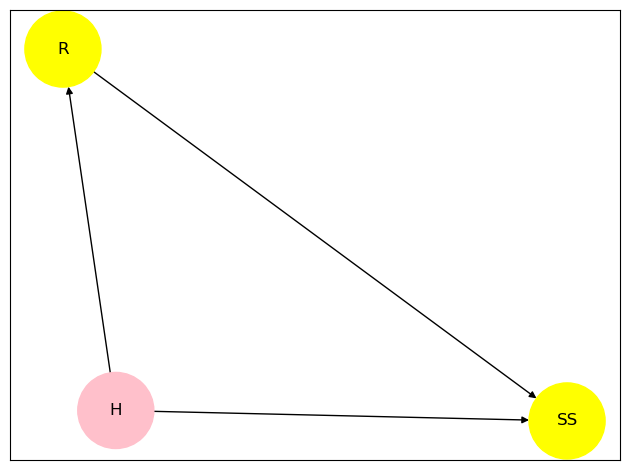

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
graph.add_edges_from([("H", "R"), ("H","SS"), ("R","SS")])
nx.draw_networkx(graph, arrows=True, node_color= ["pink", "yellow", "yellow"], node_size=3000)
plt.tight_layout()

The DAG graph above represents the causal relationships between the reach (R), height (H), and the number of significant strikes landed per min (SS). As briefly addressed in the hypothesis, the associations between the variables are made under a reasonable scientific model:

1. R_i = $f_{R} (H_i)$

The height of a fighter (H) directly influences the reach of the fighter (R) as the reach gets longer as human grows and gets taller.

2. SS_i = $f_{SS} (R_i, H_i)$

Both the the reach (R) and the height (H) directly affects the number of significant strikes landed per min since having the longer reach and being taller than the opponent means that the fighter has a bigger safety zone and easier to reach to the opponent so that one can land more significant strikes easily and safely.

Thus, as we see that the height (H) is a confounder (H affects both R and SS  [R $\leftarrow$ H $\rightarrow$ SS]), we need to condition on the height when measuring both the direct and total causal effects of the reach on the number of significant strikes landed per min; the height will be included in the model to measure both the direct and total causal effects of R on SS.

## Statistical Model

### Prior Predictive Simulation

Before the prior predictive simulation, the ufc_master.csv data will be explored.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as stats
import networkx as nx
from scipy.special import expit as logistic

In [2]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [3]:
df = pd.read_csv("Data/ufc-master.csv")
columns = ["BlueReachCms", "BlueHeightCms", "BlueAvgSigStrLanded"]
print(columns)
df = df[columns]
df.head()

['BlueReachCms', 'BlueHeightCms', 'BlueAvgSigStrLanded']


,BlueReachCms,BlueHeightCms,BlueAvgSigStrLanded
0,175.26,172.72,0.00
1,187.96,190.50,5.50
2,203.20,200.66,5.13
3,177.80,175.26,3.74
4,177.80,177.80,4.41


### Research on Average Reach, Height, and Number of Significant Strikes Landed per Min of UFC Fighters

From the research, the $\href{https://www.reference.com/science-technology/average-human-arm-span-c07bdf92e5fa8755}{Reference}$ website states that the average arm span length for man is about 5 feet 9 inches (175.26 cm). Since it was hard to find the average reach length of the UFC fighters across all weight classes, we will use this general average arm span length information for man as the average reach length of the UFC fighters. Thus, as an estimation, we are going to use the standard deviation of 10.00 cm with 175.26 cm as the average reach length of the UFC fighters.

According to the $\href{https://jokermag.com/average-height-ufc-fighters/}{jokermag}$ website, it states the average height of the UFC fighters across all weight classes is about 5 feet 9.5 inches (176.62 cm). Thus, as an estimation, we are going to use the standard deviation of 10.00 cm with 176.62 cm as the average height of the UFC fighters.

From the research, we could not find the average number of significant strikes landed per min of the UFC fighters. However, according to the $\href{http://statleaders.ufc.com/career?fighter_status=0}{Official-UFC-Record-Book}$, the highest significant strikes landed per minute is 8.10. Since the possible least significant strikes landed per minute will be 0, we are going to estimate the average number of significant strikes landed per min is 4.05 with a standard deviation of 1.

With this researched information, we see that in the plots above, there are data points which have the value for the number of significant strikes landed per min greater than 8.10. We will double-check if the pre-processed dataset has the appropriate data values for the number of significant strikes landed per min.

In [4]:
# The min of the number of significant strikes landed per min
num_sig_str = ["BlueAvgSigStrLanded"]
print("The minimum number of significant strikes landed per min:")
print(df[num_sig_str].min())

# The max of the number of significant strikes landed per min
print("\nThe maximum number of significant strikes landed per min:")
print(df[num_sig_str].max())

The minimum number of significant strikes landed per min:
BlueAvgSigStrLanded    0.0
dtype: float64

The maximum number of significant strikes landed per min:
BlueAvgSigStrLanded    154.0
dtype: float64


From the min and max values above, we see that while the minimum values is reasonable (sometimes there are some fights which ends in few seconds with just one significant attack, in which case the significant attack of the person lost would be 0), it is not reasonable that a fighter would land 154 significant strikes per minute in a fight. Also, as the official UFC Record Book states the highest significant strikes landed per min is 8.10, we can conclude that some of the data points in the datasets are not reasonable. Thus, we will further process the data points that has the number of significant strikes landed per min over 8.10. Also, before we proceed further, we will clean up and process the dataset.

In [5]:
# Cleaning dataset for any data point that has NaN value
processed_df = df.dropna()

# Cleaning dataset for any data point that has the BlueAvgSigStrLanded values greater than 8.10
processed_df = processed_df[processed_df['BlueAvgSigStrLanded'] <= 8.10]

# Cleaning dataset for any data point that has the BlueReachCms or BlueHeightCms < 100
processed_df = processed_df[(processed_df['BlueReachCms'] > 100) & (processed_df['BlueHeightCms'] >100)]

# Check if the processed dataset is clean
print("Any NaN in the processed dataset:\n", processed_df.isna().any().any())

print("\nAny number of significant strike landed per min greater than 8.10:\n", np.where(processed_df[["BlueAvgSigStrLanded"]]>8.10))

print("\nAny reach or height of the figher less than 100:\n", np.where(processed_df[["BlueReachCms", "BlueHeightCms"]]<100))

Any NaN in the processed dataset:
 False

Any number of significant strike landed per min greater than 8.10:
 (array([], dtype=int64), array([], dtype=int64))

Any reach or height of the figher less than 100:
 (array([], dtype=int64), array([], dtype=int64))


In [20]:
# The min of the number of significant strikes landed per min
num_sig_str = ["BlueAvgSigStrLanded"]
print("The minimum number of significant strikes landed per min in processed dataset:")
print(processed_df[num_sig_str].min())
print("The standardized minimum number of significant strikes landed per min in processed dataset:")
print(standardize(processed_df[num_sig_str]).min())

# The max of the number of significant strikes landed per min
print("\nThe maximum number of significant strikes landed per min in processed dataset:")
print(processed_df[num_sig_str].max())
print("The standardized maximum number of significant strikes landed per min in processed dataset:")
print(standardize(processed_df[num_sig_str]).max())

The minimum number of significant strikes landed per min in processed dataset:
BlueAvgSigStrLanded    0.0
dtype: float64
The standardized minimum number of significant strikes landed per min in processed dataset:
BlueAvgSigStrLanded   -2.4761
dtype: float64

The maximum number of significant strikes landed per min in processed dataset:
BlueAvgSigStrLanded    8.07
dtype: float64
The standardized maximum number of significant strikes landed per min in processed dataset:
BlueAvgSigStrLanded    2.631653
dtype: float64


### Plot the Real Data Points and Find Min and Max Values of Standardized Reach and Height for Ranges

We will now plot the real data points where the values for reach, height, and the number of significant strikes landed per minute. Moreover, we will be standardizing the values of reach and height for better interpretation since the magnitude and range of reach and height values are too big compared to the values of the number of significant strike per minute. Also, for the prior predictive simulation, we will be using the number of significant strike landed per minute as it is, but for fitting the statistical models to the real data, we will be standardizing the data of the number of significant strike landed per minute when it is used as the observed reference for better interpretation.

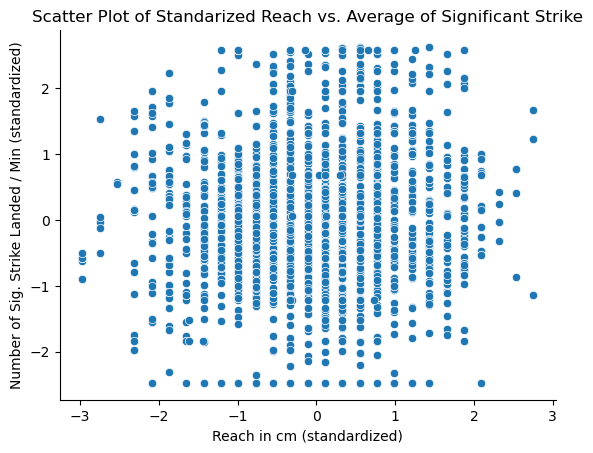

In [21]:
sns.scatterplot(x = standardize(processed_df.BlueReachCms), y = standardize(processed_df.BlueAvgSigStrLanded))
plt.xlabel("Reach in cm (standardized)")
plt.ylabel("Number of Sig. Strike Landed / Min (standardized)")
plt.title("Scatter Plot of Standarized Reach vs. Average of Significant Strike")
sns.despine();

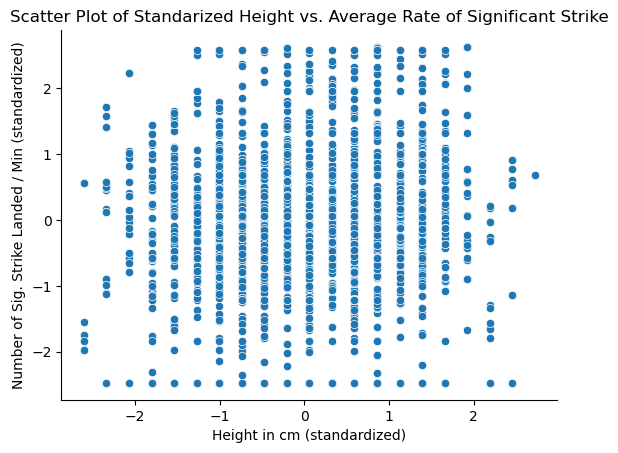

In [22]:
sns.scatterplot(x = standardize(processed_df.BlueHeightCms), y = standardize(processed_df.BlueAvgSigStrLanded))
plt.xlabel("Height in cm (standardized)")
plt.ylabel("Number of Sig. Strike Landed / Min (standardized)")
plt.title("Scatter Plot of Standarized Height vs. Average Rate of Significant Strike")
sns.despine();

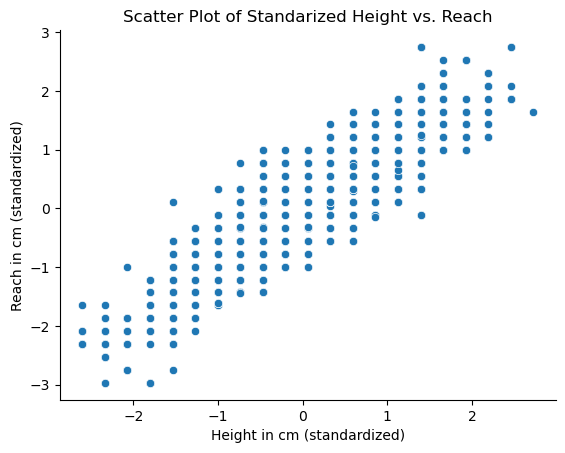

In [23]:
sns.scatterplot(x = standardize(processed_df.BlueHeightCms), y = standardize(processed_df.BlueReachCms))
plt.xlabel("Height in cm (standardized)")
plt.ylabel("Reach in cm (standardized)")
plt.title("Scatter Plot of Standarized Height vs. Reach")
sns.despine();

In [24]:
print("The minimum value of standardized reach:",standardize(processed_df["BlueReachCms"]).min())
print("The maximum value of standardized reach:",standardize(processed_df["BlueReachCms"]).max())

print("\nThe minimum value of standardized height:",standardize(processed_df["BlueHeightCms"]).min())
print("The maximum value of standardized height:",standardize(processed_df["BlueHeightCms"]).max())

The minimum value of standardized reach: -2.9723097680915673
The maximum value of standardized reach: 2.7518343339335476

The minimum value of standardized height: -2.604593436420147
The maximum value of standardized height: 2.7237521618323144


### Prior Predictive Simulations

With the min and max values of reach and height, we will set the range of the x-axis from -3 to 2.8 for the prior simulation of reach and from -2.7 to 2.8 for the prior simulation of height. The range of the y-axis will be set from -2.5 to 2.7 since the min and max values of the standardized number of significant strike landed per minute are -2.48 and 2.63 respectively.

Based one the causal relationship we examined with the DAG graph, we will formulate the statistical model with the predictive priors for reach and height.

As the statistical model for the total and direct causal effect of the reach on the number of significant strike landed per minute, 

- We previously formulated the causal model as $SS_i = f_{ss}(R_i, H_i)$ where the height is included in the model as the predictor variable since it is conditioned on for being a confounder, as well as the reach which is in the model as the treatment variable. Elaborating the causal model more in detail, we will use the standard distribution for the number of significant strike landed per minute, which is the normal distribution, where $\mu_i$ is the expectation value of the number of significant strikes landed per minute and $\sigma$ is the standard deviation of the number of significant strikes landed per minute.

- The $\sigma$ will be set with the exponential distribution with lambda of 1 as one of the standard distributions assigned for $\sigma$.

- The $\mu_i$ will be set with the linear equation ($\mu_i = \alpha + \beta_R R_i + \beta_H H_i$) which is deterministic, where $\alpha$ is the value of $\mu$ when $R_i$ and $H_i$ are 0 and $\beta_R$ and $\beta_H$ are the prior distribution for reach and height that we will explore and find the reasonable ones for them. 

- The $\alpha$, which is the y-intercept of the number of significant strikes landed per minute will be set with the normal distribution with its $\mu$ and $\sigma$ are set with the average and standard deviation of the standardized number of significant strike landed per minute, which are 0.08 and 1.

Thus, for the first prior predictive simulation, we will try the normal distribution with $\mu$ = 0 and $\sigma$ = 10 for $\beta_R$ and $\beta_H$:

$SS_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_R R_i + \beta_H H_i$

$\alpha \sim Normal(0.08, 1.0)$

$\beta_R \sim Normal(0, 10)$

$\beta_H \sim Normal(0, 10)$

$\sigma \sim Exponential(1)$

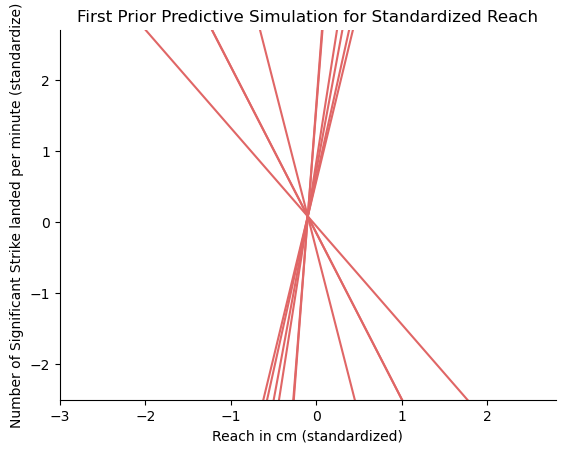

In [25]:
# First prior predictive simulation for reach
NUM_LINES = 10

x_seq = np.linspace(-3, 2.8, 50)

alpha = stats.norm.rvs(0.08, 1.0, size=NUM_LINES, random_state = 42)
beta_R = stats.norm.rvs(0, 10, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    mu = alpha[i] + beta_R[i] * x_seq
    _ = plt.plot(x_seq, mu, color="#e06666")
    
_ = plt.ylabel("Number of Significant Strike landed per minute (standardize)")
_ = plt.xlabel("Reach in cm (standardized)")
_ = plt.title("First Prior Predictive Simulation for Standardized Reach")
_ = plt.xlim(-3, 2.8)
_ = plt.ylim(-2.5, 2.7)
sns.despine();

From the plot above on the first prior predictive simulation of reach with $\beta_R \sim Normal(0, 10)$, it is reasonable for the prior lines to have either positive or negative slope since increasing reach could result in either increase or decrease of the number of significant strike landed per minute; while we can generalize it for reach and height that increasing reach and height would always increase the number of significant strikes landed per minute, we will include the possibility of increasing reach and height resulting in decrease of number of significant strike landed per minute.

However, the small increases of the reach length lead to the dramatic expected number of significant strike landed per minute. Thus, the prior lines are not representing the realistic relations between the length of reach and the number of significant strike landed per minute. Moreover, throughout the range of the reach, the expected standardized number of significant strike landed per minute exceed its desired range, which is from -2.48 and 2.63.

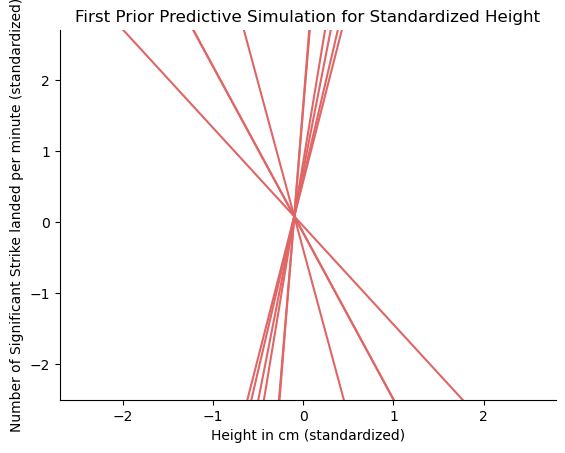

In [33]:
# First prior predictive simulation for height
NUM_LINES = 10

x_seq = np.linspace(-2.7, 2.8, 50)

alpha = stats.norm.rvs(0.08, 1.0, size=NUM_LINES, random_state = 42)
beta_H = stats.norm.rvs(0, 10, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    mu = alpha[i] + beta_H[i] * x_seq
    _ = plt.plot(x_seq, mu, color="#e06666")
    
_ = plt.ylabel("Number of Significant Strike landed per minute (standardized)")
_ = plt.xlabel("Height in cm (standardized)")
_ = plt.title("First Prior Predictive Simulation for Standardized Height")
_ = plt.xlim(-2.7, 2.8)
_ = plt.ylim(-2.5, 2.7)
sns.despine();

The plot above is the first prior predictive simulation of height with $\beta_H \sim Normal(0, 10)$. Similar to the prior lines simulated for reach, it is reasonable for the prior lines to have either positive or negative slope since increasing height could result in either increase or decrease of the number of significant strike landed per minute.

However, the small increases of the height lead to the dramatic expected number of significant strike landed per minute. Thus, the prior lines for relation of height and the number of significant strike landed per minute are also not representing the realistic relations between the heights and the number of significant strike landed per minute. Furthermore, this plot also shows that within the range of the height, the expected number of significant strike landed per minute exceeds the desired range from -2.48 and 2.63.

Thus, we concluded that setting the prior distribution as $\beta_R \sim Normal(0, 10)$ and $\beta_H \sim Normal(0, 10)$ for reach and height, respectively, represent not realistic relations of each variable with the number of significant strike landed per minute. However, we analyzed that it is appropriate to use the normal distribution for both beta as the normal distribution generates either positive or negative relations between each variable with the number of significant strike landed per minute, which we desired as described before.

As a result, we will continue to use the normal distribution for both beta and for the second prior predictive simulation of each variable, we will change the standard deviation of the normal distribution from 10 to 0.3, which will decrease the magnitude of the beta when it is randomly sampled.

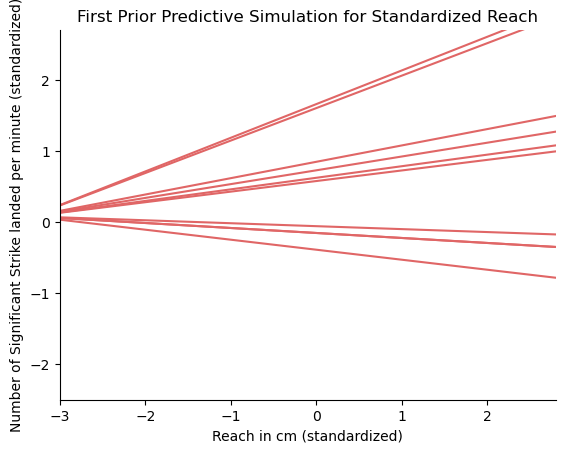

In [34]:
# Second prior predictive simulation for reach
NUM_LINES = 10

x_seq = np.linspace(-3, 2.8, 50)

alpha = stats.norm.rvs(0.08, 1.0, size=NUM_LINES, random_state = 42)
beta_R = stats.norm.rvs(0, 0.3, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    mu = alpha[i] + beta_R[i] * x_seq
    _ = plt.plot(x_seq, mu, color="#e06666")
    
_ = plt.ylabel("Number of Significant Strike landed per minute (standardized)")
_ = plt.xlabel("Reach in cm (standardized)")
_ = plt.title("First Prior Predictive Simulation for Standardized Reach")
_ = plt.xlim(-3, 2.8)
_ = plt.ylim(-2.5, 2.7)
sns.despine();

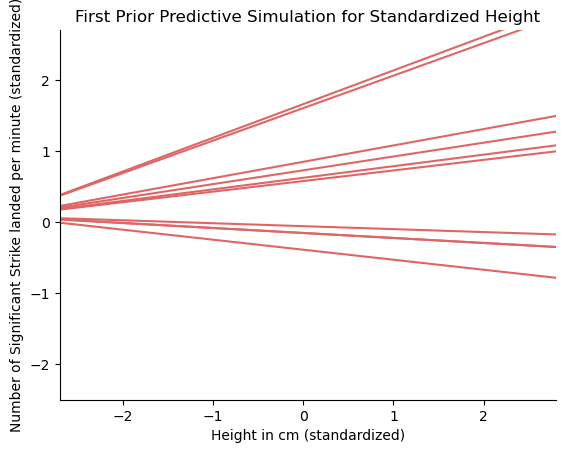

In [35]:
# Second prior predictive simulation for height
NUM_LINES = 10

x_seq = np.linspace(-2.7, 2.8, 50)

alpha = stats.norm.rvs(0.08, 1.0, size=NUM_LINES, random_state = 42)
beta_H = stats.norm.rvs(0, 0.3, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    mu = alpha[i] + beta_H[i] * x_seq
    _ = plt.plot(x_seq, mu, color="#e06666")
    
_ = plt.ylabel("Number of Significant Strike landed per minute (standardized)")
_ = plt.xlabel("Height in cm (standardized)")
_ = plt.title("First Prior Predictive Simulation for Standardized Height")
_ = plt.xlim(-2.7, 2.8)
_ = plt.ylim(-2.5, 2.7)
sns.despine();

As illustrated in the above for the second prior predictive simulations for reach and height, we observe that each prior plot has either positive or negative slope, which expected. Also, the little increases in reach or height lead to moderate expected standardized number of significant strike landed per minute, which the expected number of significant strike landed per minute stays within the desired range which are from -2.48 and 2.63. Thus, we concluded that for both reach and height, the normal distribution with $\mu$ = 0 and $\sigma$ = 0.3 is the appropriate prior distribution.

### Fit the Model

With the statistical model that we defined and the prior distribution that we found reasonable in the previous section, we will fit the model with the dataset we processed before. Also, as explained before, height is included in the model as a predictor variable since it is a confounder that affects both the number of significant strike landed per minute and reach. The reach is included in the model as a treatment variable which we are interested to examine its influence on the target variable. Lastly, the number of significant strike landed per minute is included in the model as the target variable. Furthermore, as mentioned before, the standardized values of reach and height will be used for better interpretation since their large range of values and magnitude.

Moreover, we will also analyze the quadratic and cubic regression models as well as the linear regression model, which the deterministic equation $\mu_i$ will be changed to $\mu_i = \alpha + \beta_R R_i + \beta_R R_i^2 + \beta_H H_i + \beta_H H_i^2$ and $\mu_i = \alpha + \beta_R R_i + \beta_R R_i^2 + \beta_R R_i^3 + \beta_H H_i + \beta_H H_i^2 + \beta_H H_i^3$, respectively.

Statistical models we defined with the selected prior distribution:

Linear model:

$SS_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_R R_i + \beta_H H_i$

$\alpha \sim Normal(0.08, 1.0)$

$\beta_R \sim Normal(0, 0.3)$

$\beta_H \sim Normal(0, 0.3)$

$\sigma \sim Exponential(1)$

Quadratic model:

$SS_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_R R_i + \beta_R R_i^2 + \beta_H H_i + \beta_H H_i^2$

$\alpha \sim Normal(0.08, 1.0)$

$\beta_R \sim Normal(0, 0.3)$

$\beta_H \sim Normal(0, 0.3)$

$\sigma \sim Exponential(1)$

Cubic model:

$SS_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_R R_i + \beta_R R_i^2 + \beta_R R_i^3 + \beta_H H_i + \beta_H H_i^2 + \beta_H H_i^3$

$\alpha \sim Normal(0.08, 1.0)$

$\beta_R \sim Normal(0, 0.3)$

$\beta_H \sim Normal(0, 0.3)$

$\sigma \sim Exponential(1)$

In [36]:
reach_std = standardize(processed_df.BlueReachCms)
height_std = standardize(processed_df.BlueHeightCms)
SigStr_std = standardize(processed_df.BlueAvgSigStrLanded)

In [42]:
# Fit the linear model with processed data
with pm.Model() as linM:
    alpha = pm.Normal('alpha', mu = 0.08, sigma = 1.0)
    beta_R = pm.Normal('beta_R', mu = 0, sigma = 0.3)
    beta_H = pm.Normal('beta_H', mu = 0, sigma = 0.3)
    sigma = pm.Exponential('sigma', 1)
    
    mu = pm.Deterministic('mu', alpha + beta_R * reach_std + beta_H * height_std)
    SS = pm.Normal('SigStr', mu, sigma, observed = SigStr_std)

    idata_lin = pm.sample(return_inferencedata=True, random_seed=42, idata_kwargs={"log_likelihood": True})

az.summary(idata_lin, var_names = ['alpha', 'beta_R', 'beta_H', 'sigma'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_R, beta_H, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%
alpha,0.000,0.019,-0.035,0.033
beta_R,-0.049,0.044,-0.132,0.030
beta_H,0.120,0.044,0.039,0.201
sigma,0.998,0.013,0.975,1.022


In [43]:
# Fit the quadratic model with processed data
with pm.Model() as quadM:
    alpha = pm.Normal('alpha', mu = 4.05, sigma = 1.0)
    beta_R = pm.Normal('beta_R', mu = 0, sigma = 0.3)
    beta_R2 = pm.Normal('beta_R2', mu = 0, sigma = 0.3)
    beta_H = pm.Normal('beta_H', mu = 0, sigma = 0.3)
    beta_H2 = pm.Normal('beta_H2', mu = 0, sigma = 0.3)
    sigma = pm.Exponential('sigma', 1)

    mu = pm.Deterministic('mu', alpha + beta_R * reach_std
                          + beta_R2 * reach_std ** 2 
                          + beta_H * height_std
                          + beta_H2 * height_std ** 2)
    SS = pm.Normal('SigStr', mu, sigma, observed = SigStr_std)

    idata_quad = pm.sample(return_inferencedata=True, random_seed=42, idata_kwargs={"log_likelihood": True})
    
az.summary(idata_quad, var_names = ['alpha', 'beta_R', 'beta_R2', 'beta_H', 'beta_H2', 'sigma'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_R, beta_R2, beta_H, beta_H2, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%
alpha,-0.015,0.025,-0.060,0.031
beta_R,-0.045,0.044,-0.126,0.037
beta_R2,0.002,0.022,-0.041,0.043
beta_H,0.117,0.044,0.031,0.196
beta_H2,0.014,0.025,-0.035,0.060
sigma,0.997,0.013,0.974,1.021


In [44]:
# Fit the cubic model with processed data
with pm.Model() as cubM:
    alpha = pm.Normal('alpha', mu = 4.05, sigma = 1.0)
    beta_R = pm.Normal('beta_R', mu = 0, sigma = 0.3)
    beta_R2 = pm.Normal('beta_R2', mu = 0, sigma = 0.3)
    beta_R3 = pm.Normal('beta_R3', mu = 0, sigma = 0.3)
    beta_H = pm.Normal('beta_H', mu = 0, sigma = 0.3)
    beta_H2 = pm.Normal('beta_H2', mu = 0, sigma = 0.3)
    beta_H3 = pm.Normal('beta_H3', mu = 0, sigma = 0.3)
    sigma = pm.Exponential('sigma', 1)

    mu = pm.Deterministic('mu', alpha + beta_R * reach_std
                          + beta_R2 * reach_std ** 2 
                          + beta_R3 * reach_std ** 3 
                          + beta_H * height_std
                          + beta_H2 * height_std ** 2
                          + beta_H3 * height_std ** 3)
    SS = pm.Normal('SigStr', mu, sigma, observed = SigStr_std)

    idata_cub = pm.sample(return_inferencedata=True, random_seed=42, idata_kwargs={"log_likelihood": True})

az.summary(idata_cub, var_names = ['alpha', 'beta_R', 'beta_R2', 'beta_R3', 'beta_H', 'beta_H2', 'beta_H3', 'sigma'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_R, beta_R2, beta_R3, beta_H, beta_H2, beta_H3, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%
alpha,-0.013,0.025,-0.061,0.033
beta_R,-0.073,0.057,-0.173,0.040
beta_R2,0.001,0.022,-0.040,0.042
beta_R3,0.010,0.012,-0.010,0.033
beta_H,0.172,0.057,0.070,0.280
beta_H2,0.014,0.024,-0.033,0.055
beta_H3,-0.022,0.014,-0.049,0.004
sigma,0.998,0.013,0.973,1.023


In [45]:
models = {
    'linear': idata_lin,
    'quadratic': idata_quad,
    'cubic': idata_cub
}

In [46]:
compare_psis = az.compare(
    compare_dict=models,
    ic="loo",
    scale="deviance"
)
compare_psis

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear,0,7819.407561,4.052768,0.000000,0.998012,80.762858,0.000000,False,deviance
quadratic,1,7822.560051,6.265487,3.152490,0.000000,81.005536,2.132886,False,deviance
cubic,2,7823.846897,8.291492,4.439336,0.001988,80.922587,4.343095,False,deviance


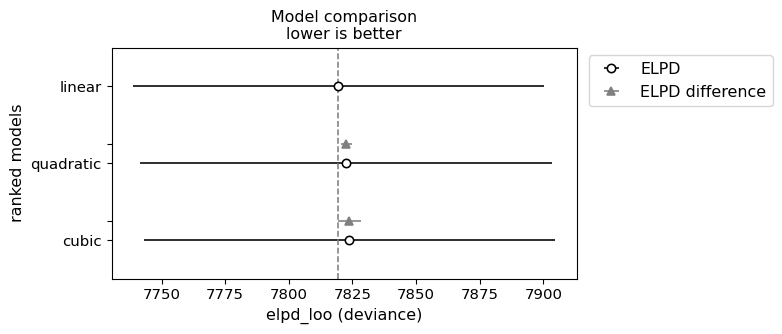

In [47]:
_ = az.plot_compare(compare_psis)

In [48]:
compare_waic = az.compare(
    compare_dict=models,
    ic="waic",
    scale="deviance"
)
compare_waic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
linear,0,7819.386664,4.042320,0.000000,9.956881e-01,80.762205,0.000000,False,deviance
quadratic,1,7822.529509,6.250216,3.142845,2.914815e-15,81.004646,2.132801,False,deviance
cubic,2,7823.806338,8.271213,4.419675,4.311899e-03,80.921526,4.342608,False,deviance


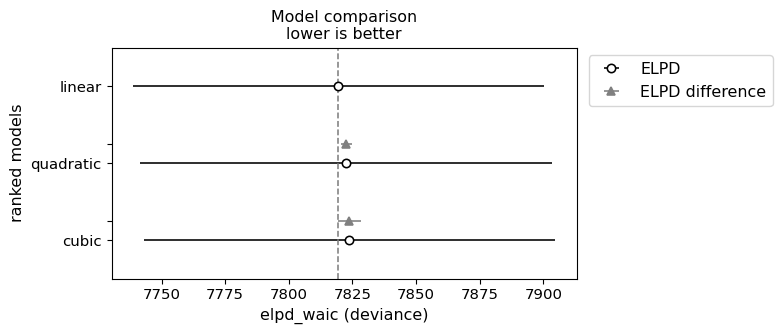

In [49]:
_ = az.plot_compare(compare_waic)